In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import BorderlineSMOTE
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.under_sampling import NearMiss

2025-03-03 02:37:03.042684: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 02:37:03.045427: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 02:37:03.054667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740965823.069065    7836 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740965823.073213    7836 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 02:37:03.088096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
xtrain_df = pd.read_csv('task/train_set/x_train.csv')
xtrain_agg_df = pd.read_csv('task/train_set/x_train_aggregated.csv')
ytrain_df = pd.read_csv('task/train_set/y_train.csv')
xval_agg_df = pd.read_csv('task/validation_set/x_val_aggregated.csv')
yval_df = pd.read_csv('task/validation_set/y_val.csv')

In [3]:
df = pd.DataFrame(xtrain_agg_df, columns=[
    "NumTransactions", "AvgAmount", "MaxAmount", 
    "TotalIn", "MaxIn", "TotalOut", "MaxCashOut", 
    "MaxDebit", "MaxTransfer", "MaxPayment", "MaxFreqH", "MaxFreqD"
])

# Add the Fraudster column (y values)
df["Fraudster"] = ytrain_df["Fraudster"]

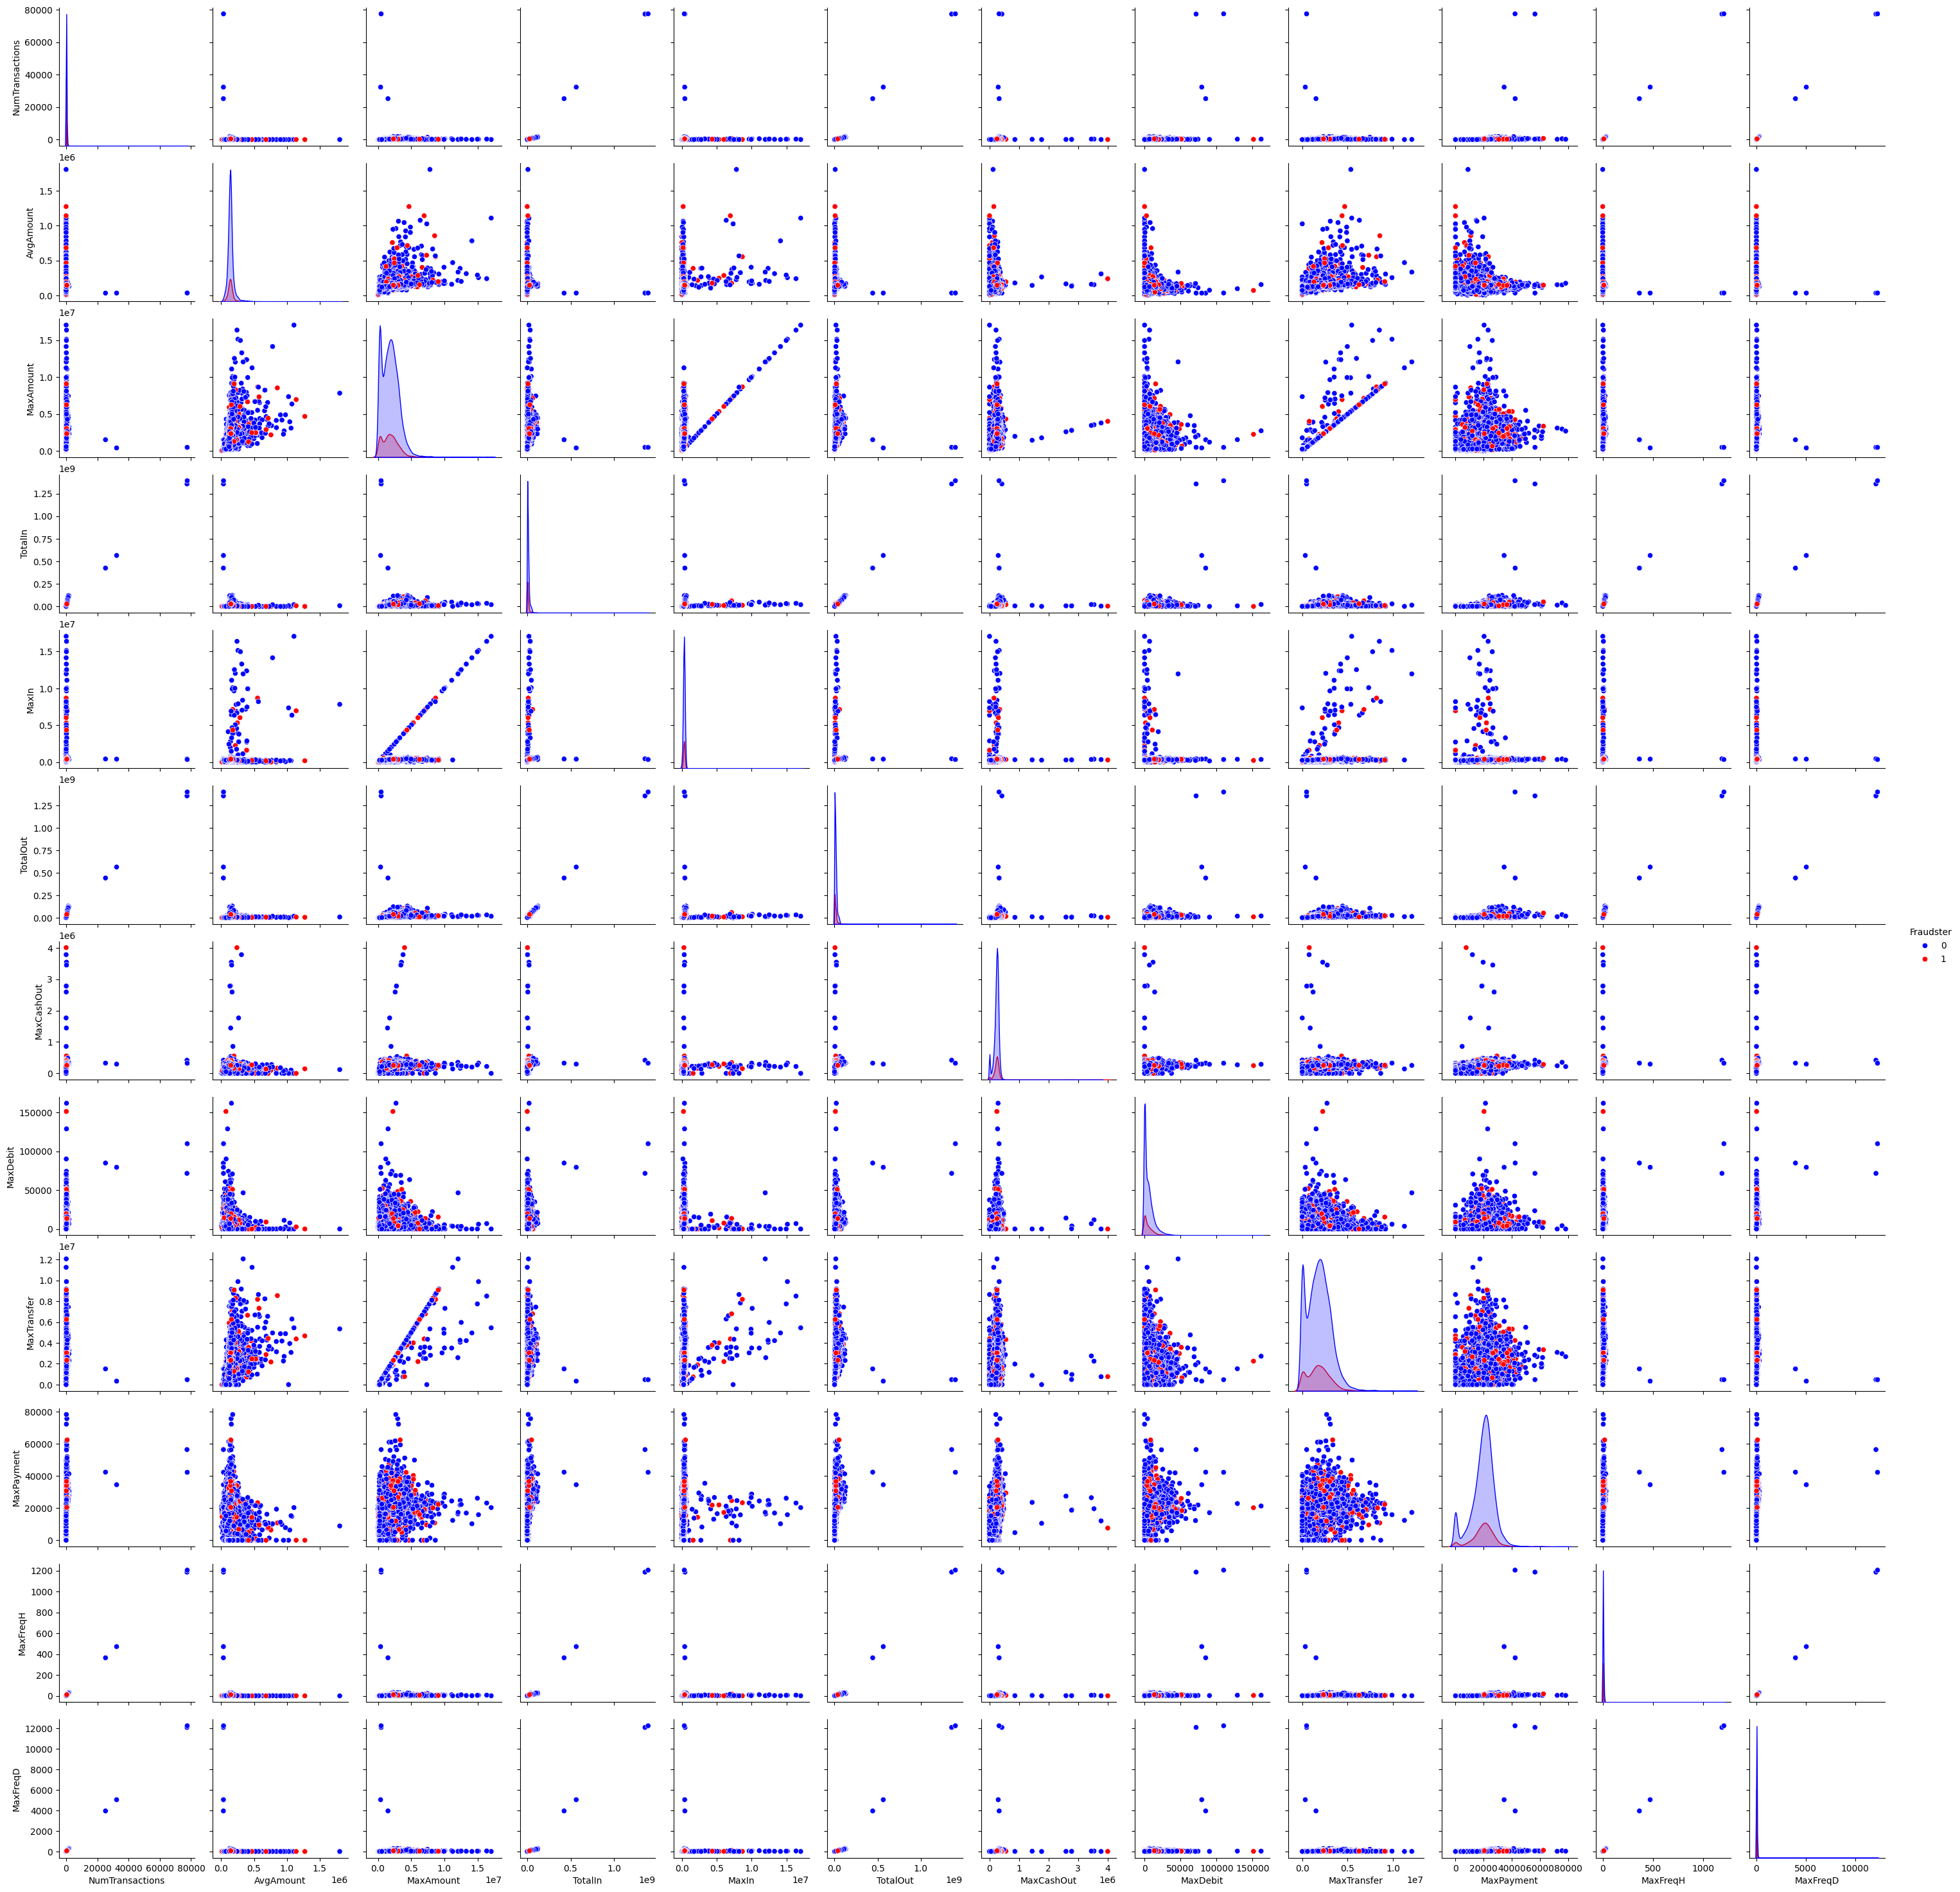

In [4]:
features = [
    "NumTransactions", "AvgAmount", "MaxAmount", 
    "TotalIn", "MaxIn", "TotalOut", "MaxCashOut", 
    "MaxDebit", "MaxTransfer", "MaxPayment", "MaxFreqH", "MaxFreqD"
]

# Pairplot with fraud cases highlighted
sns.pairplot(df, vars=features, hue="Fraudster", diag_kind="kde", palette={0: "blue", 1: "red"})

plt.show()

In [5]:
print('No Frauds', round(ytrain_df['Fraudster'].value_counts()[0]/len(ytrain_df) * 100,2), '% of the dataset')
print('Frauds', round(ytrain_df['Fraudster'].value_counts()[1]/len(ytrain_df) * 100,2), '% of the dataset')

No Frauds 84.29 % of the dataset
Frauds 15.71 % of the dataset


Fraudster
0    0.842871
1    0.157129
Name: count, dtype: float64


/tmp/ipykernel_7836/29030841.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fraudster', data=df, palette=colors)


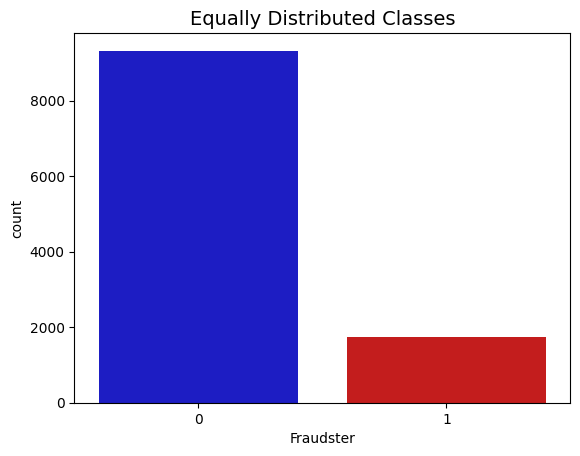

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each class in the 'Fraudster' column
print(df['Fraudster'].value_counts() / len(df))

# Define colors for the plot
colors = ["#0101DF", "#DF0101"]

# Corrected `sns.countplot()` syntax (use `x=` instead of passing column as a positional argument)
sns.countplot(x='Fraudster', data=df, palette=colors)

# Add title and show plot
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()


In [7]:
x = xtrain_agg_df[['NumTransactions','AvgAmount','MaxAmount','TotalIn','MaxIn','TotalOut','MaxCashOut','MaxDebit','MaxTransfer','MaxPayment','MaxFreqH','MaxFreqD']]
y = ytrain_df['Fraudster']
xval = xval_agg_df[['NumTransactions','AvgAmount','MaxAmount','TotalIn','MaxIn','TotalOut','MaxCashOut','MaxDebit','MaxTransfer','MaxPayment','MaxFreqH','MaxFreqD']]
yval = yval_df['Fraudster']

In [8]:
scaler = RobustScaler().fit(x)
x = scaler.transform(x)

scaler = RobustScaler().fit(xval)
xval = scaler.transform(xval)

In [20]:
df = pd.DataFrame(x, columns=[
    "NumTransactions", "AvgAmount", "MaxAmount", 
    "TotalIn", "MaxIn", "TotalOut", "MaxCashOut", 
    "MaxDebit", "MaxTransfer", "MaxPayment", "MaxFreqH", "MaxFreqD"
])

# Add the Fraudster column (y values)
df["Fraudster"] = ytrain_df["Fraudster"]

In [21]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df1 = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df1['Fraudster'] == 1]
non_fraud_df = df.loc[df1['Fraudster'] == 0][:1738]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,NumTransactions,AvgAmount,MaxAmount,TotalIn,MaxIn,TotalOut,MaxCashOut,MaxDebit,MaxTransfer,MaxPayment,MaxFreqH,MaxFreqD,Fraudster
385,-0.539773,-2.199535,-0.895869,-0.541294,-3.297051,-0.555022,-0.524282,-0.384650,-1.011775,-0.932659,-0.75,-0.500000,0
9055,0.505682,-0.410965,0.292759,0.563508,-0.074796,0.182713,0.315561,-0.150932,0.295668,0.615492,0.50,0.392857,1
1919,-0.471591,-1.041956,-0.869659,-0.456714,-0.637268,-0.525780,-1.893088,-0.384650,-0.870515,-1.399611,-0.50,-0.500000,1
633,-0.431818,0.030809,-0.835587,-0.269470,0.004983,-0.563064,-2.993247,-0.384650,-0.943850,-2.416981,-0.50,-0.428571,0
1547,-0.045455,0.457244,0.956448,0.187674,0.043279,-0.159044,-0.567942,0.724750,0.961353,-0.052320,-0.25,-0.214286,0


Fraudster
0    0.5
1    0.5
Name: count, dtype: float64


/tmp/ipykernel_7836/1454745386.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fraudster', data=new_df, palette=colors)


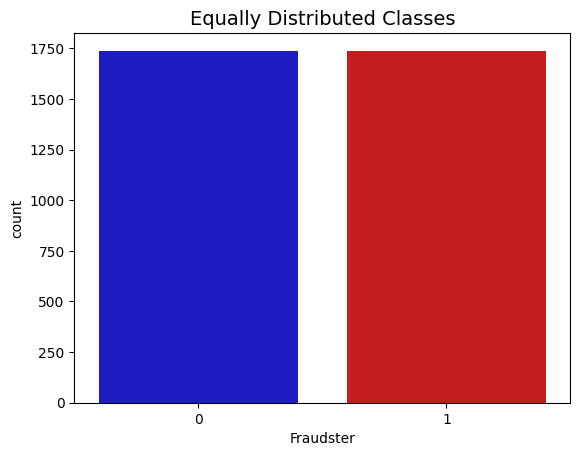

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each class in the 'Fraudster' column
print(new_df['Fraudster'].value_counts() / len(new_df))

# Define colors for the plot
colors = ["#0101DF", "#DF0101"]

# Corrected `sns.countplot()` syntax (use `x=` instead of passing column as a positional argument)
sns.countplot(x='Fraudster', data=new_df, palette=colors)

# Add title and show plot
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()


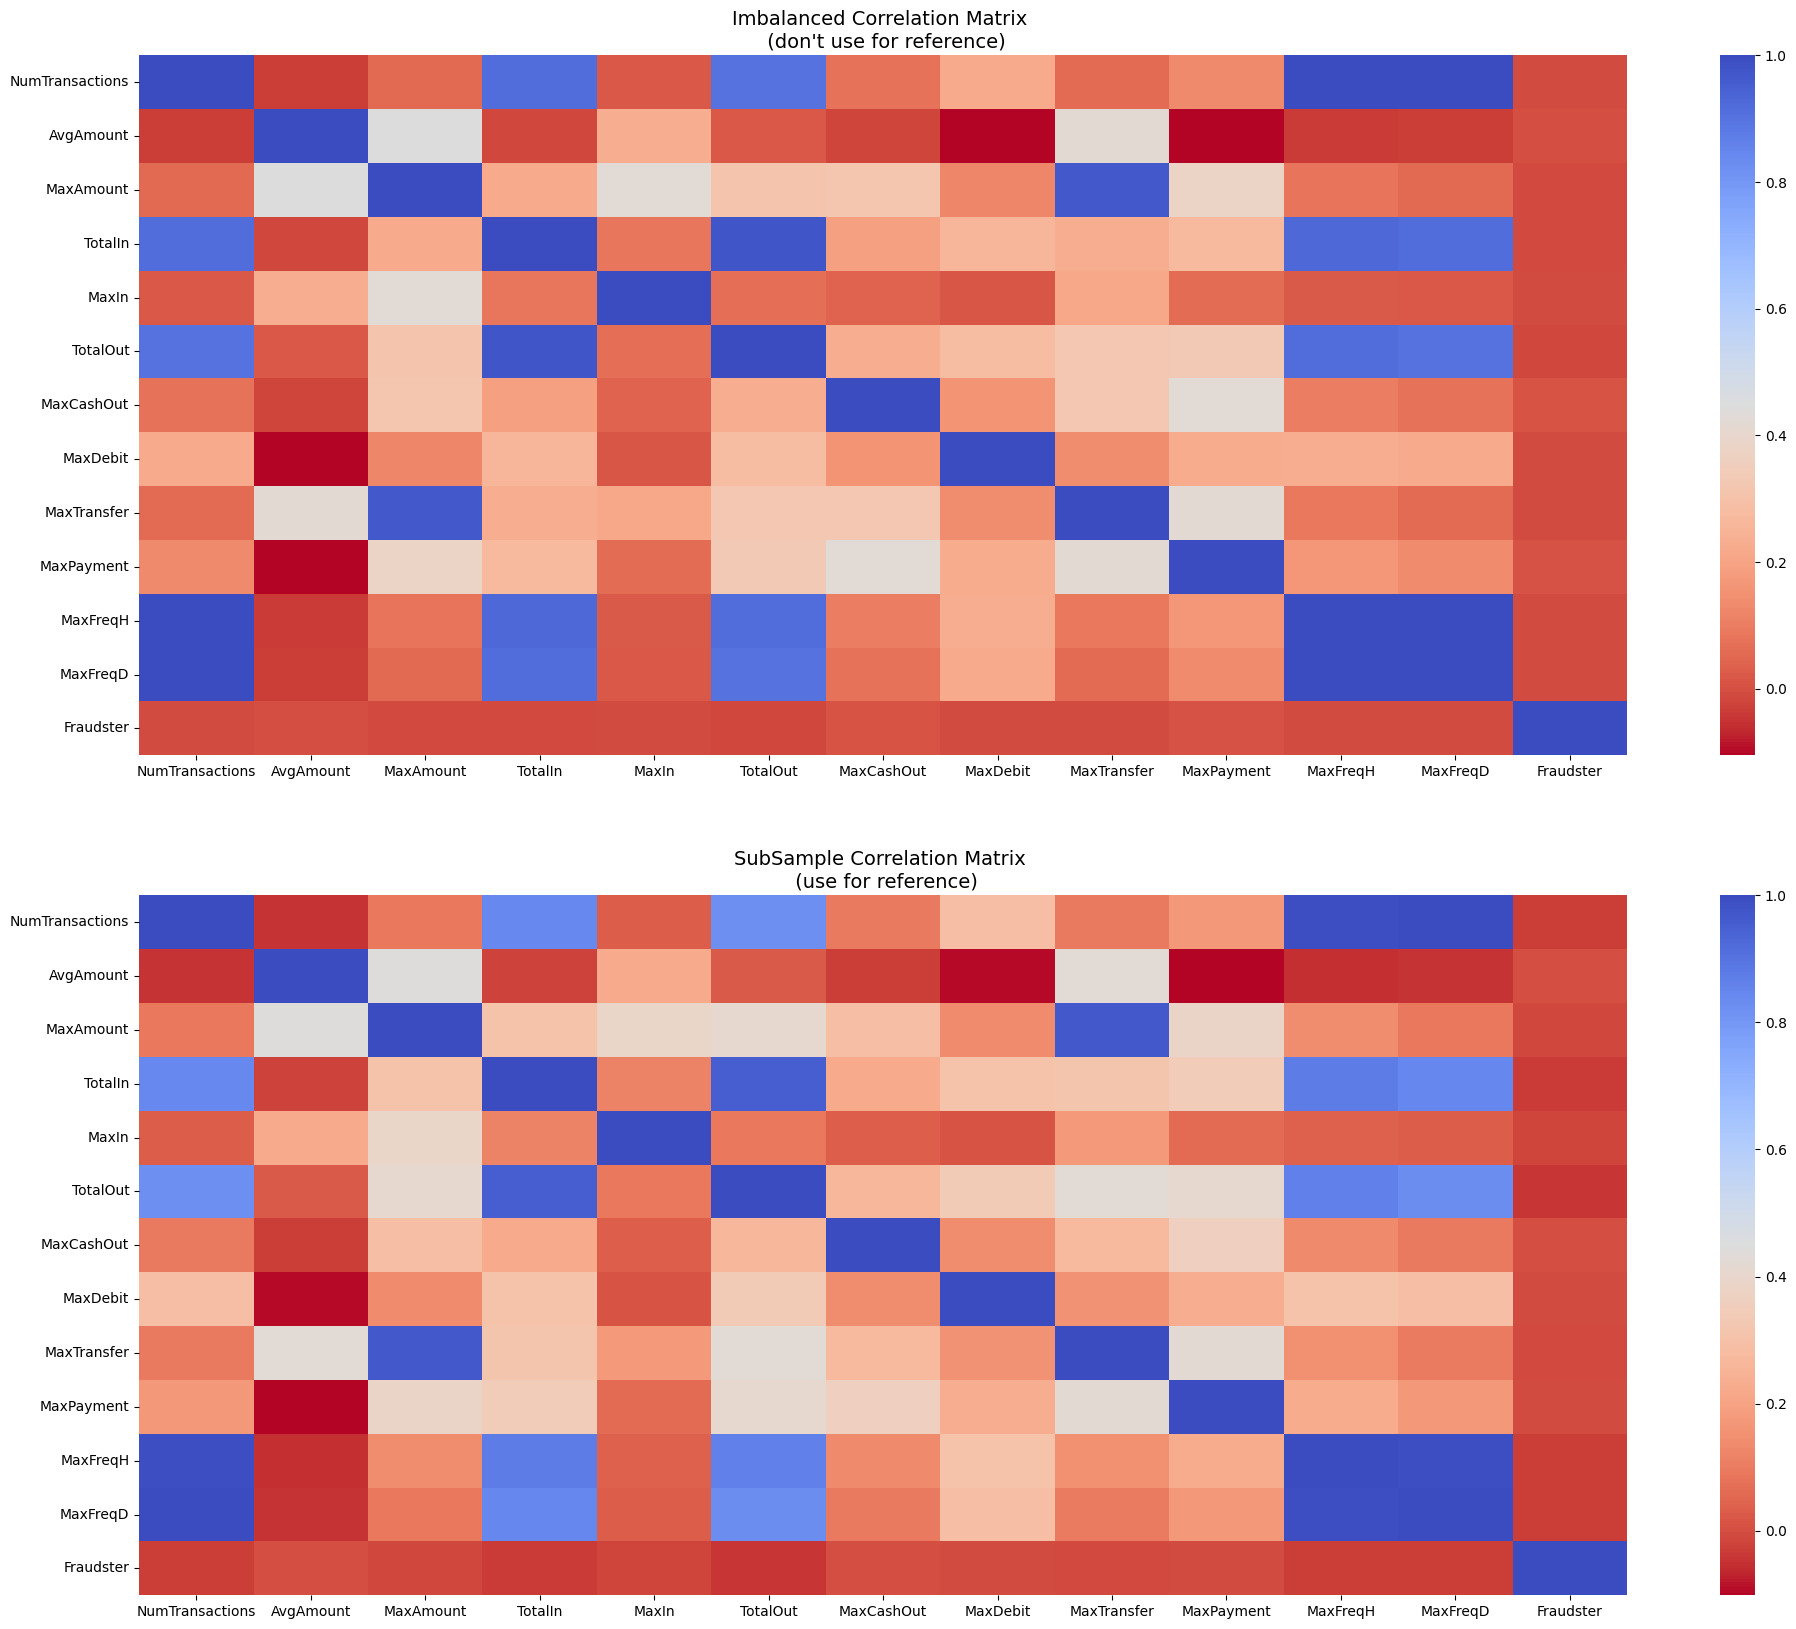

In [23]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

/tmp/ipykernel_7836/3154893706.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fraudster", y="NumTransactions", data=new_df, palette=colors, ax=axes[0])
/tmp/ipykernel_7836/3154893706.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fraudster", y="AvgAmount", data=new_df, palette=colors, ax=axes[1])
/tmp/ipykernel_7836/3154893706.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fraudster", y="MaxAmount", data=new_df, palette=colors, ax=axes[2])
/tmp/ipykernel_7836/3154893706.py:15: FutureWarning: 

Passing `palette` witho

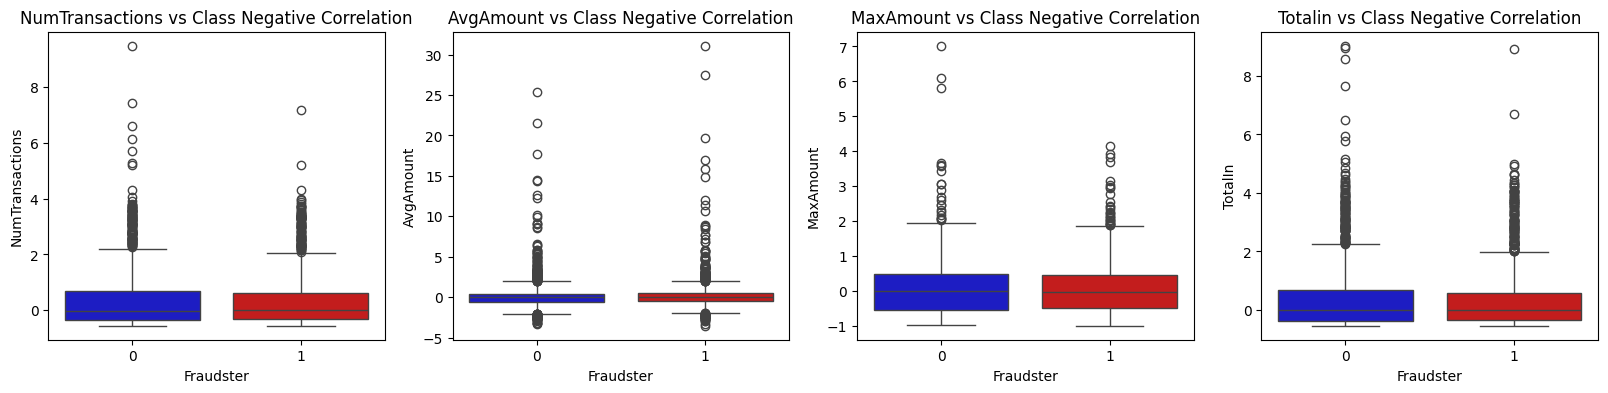

In [13]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Fraudster", y="NumTransactions", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('NumTransactions vs Class Negative Correlation')

sns.boxplot(x="Fraudster", y="AvgAmount", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('AvgAmount vs Class Negative Correlation')


sns.boxplot(x="Fraudster", y="MaxAmount", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('MaxAmount vs Class Negative Correlation')


sns.boxplot(x="Fraudster", y="TotalIn", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('Totalin vs Class Negative Correlation')

plt.show()

/tmp/ipykernel_7836/2685853704.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fraudster", y="MaxIn", data=new_df, palette=colors, ax=axes[0])
/tmp/ipykernel_7836/2685853704.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fraudster", y="TotalOut", data=new_df, palette=colors, ax=axes[1])
/tmp/ipykernel_7836/2685853704.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fraudster", y="MaxCashOut", data=new_df, palette=colors, ax=axes[2])
/tmp/ipykernel_7836/2685853704.py:15: FutureWarning: 

Passing `palette` without assigni

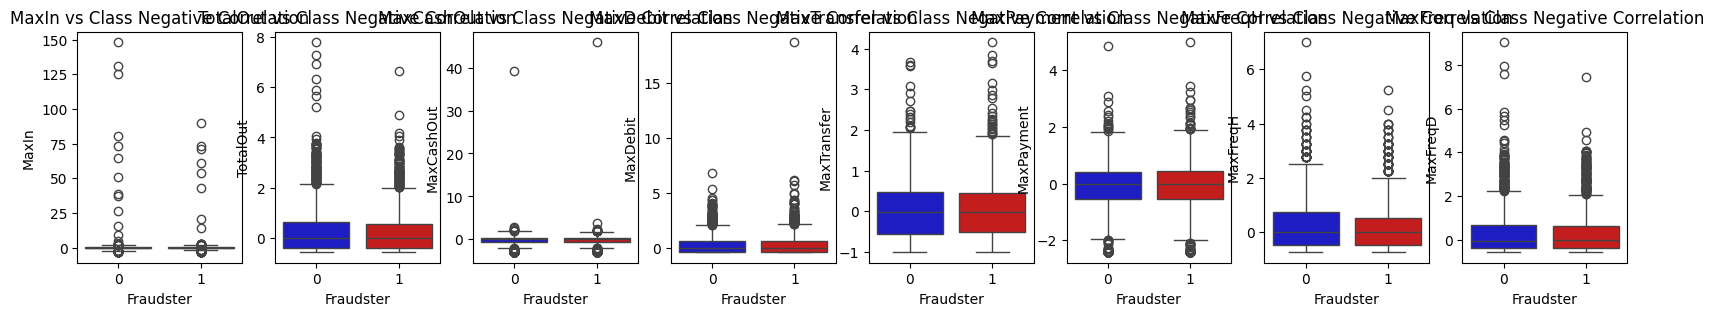

In [14]:
f, axes = plt.subplots(ncols=8, figsize=(20,3))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Fraudster", y="MaxIn", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('MaxIn vs Class Negative Correlation')

sns.boxplot(x="Fraudster", y="TotalOut", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('TotalOut vs Class Negative Correlation')


sns.boxplot(x="Fraudster", y="MaxCashOut", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('MaxCashOut vs Class Negative Correlation')


sns.boxplot(x="Fraudster", y="MaxDebit", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('MaxDebit vs Class Negative Correlation')

sns.boxplot(x="Fraudster", y="MaxTransfer", data=new_df, palette=colors, ax=axes[4])
axes[4].set_title('MaxTransfer vs Class Negative Correlation')

sns.boxplot(x="Fraudster", y="MaxPayment", data=new_df, palette=colors, ax=axes[5])
axes[5].set_title('MaxPayment vs Class Negative Correlation')


sns.boxplot(x="Fraudster", y="MaxFreqH", data=new_df, palette=colors, ax=axes[6])
axes[6].set_title('MaxFreqH vs Class Negative Correlation')


sns.boxplot(x="Fraudster", y="MaxFreqD", data=new_df, palette=colors, ax=axes[7])
axes[7].set_title('MaxFreq vs Class Negative Correlation')
plt.show()

In [15]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Fraudster', axis=1)
y = new_df['Fraudster']

In [16]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [18]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

/home/harsha/anaconda3/envs/bbdc25/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/harsha/anaconda3/envs/bbdc25/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/harsha/anaconda3/envs/bbdc25/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/harsha/anaconda3/envs/bbdc25/lib/python3.1

In [19]:
from sklearn.model_selection import cross_val_score

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')
print(confusion_matrix(yval, y_pred))

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  50.0%


NameError: name 'y_pred' is not defined

In [ ]:
from collections import Counter
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
x = xtrain_agg_df[['NumTransactions','AvgAmount','MaxAmount','TotalIn','MaxIn','TotalOut','MaxCashOut','MaxDebit','MaxTransfer','MaxPayment','MaxFreqH','MaxFreqD']]
y = ytrain_df['Fraudster']

print(x.shape, y.shape)

for train_index, test_index in sss.split(x, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = x.iloc[train_index], x.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values



undersample_X = df.drop('Fraudster', axis=1)
undersample_y = df['Fraudster']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []
undersample_matrices =[]
# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))
    undersample_matrices.append(confusion_matrix(original_ytrain[test], undersample_prediction))
    

(11061, 12) (11061,)
Train: [ 2168  2175  2182 ... 11058 11059 11060] Test: [   0    1    2 ... 2218 2219 2220]
Train: [    0     1     2 ... 11058 11059 11060] Test: [2168 2175 2182 ... 4435 4436 4437]
Train: [    0     1     2 ... 11058 11059 11060] Test: [4420 4421 4422 ... 6692 6699 6713]
Train: [    0     1     2 ... 11058 11059 11060] Test: [6624 6625 6626 ... 8848 8850 8852]
Train: [   0    1    2 ... 8848 8850 8852] Test: [ 8804  8821  8849 ... 11058 11059 11060]
Train: [ 2168  2175  2182 ... 11058 11059 11060] Test: [   0    1    2 ... 2218 2219 2220]
Train: [    0     1     2 ... 11058 11059 11060] Test: [2168 2175 2182 ... 4435 4436 4437]
Train: [    0     1     2 ... 11058 11059 11060] Test: [4420 4421 4422 ... 6692 6699 6713]
Train: [    0     1     2 ... 11058 11059 11060] Test: [6624 6625 6626 ... 8848 8850 8852]
Train: [   0    1    2 ... 8848 8850 8852] Test: [ 8804  8821  8849 ... 11058 11059 11060]
NearMiss Label Distribution: Counter({np.int64(0): 1738, np.int64(1):

In [42]:
print(undersample_matrices)

[array([[537, 955],
       [120, 158]]), array([[514, 978],
       [102, 176]]), array([[ 480, 1012],
       [  86,  192]]), array([[ 492, 1000],
       [  89,  189]]), array([[538, 953],
       [ 93, 185]])]


In [38]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [39]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.49977328676222443
KNears Neighbors:  0.506779139897596
Support Vector Classifier:  0.522778469074865
Decision Tree Classifier:  0.5153559397833076


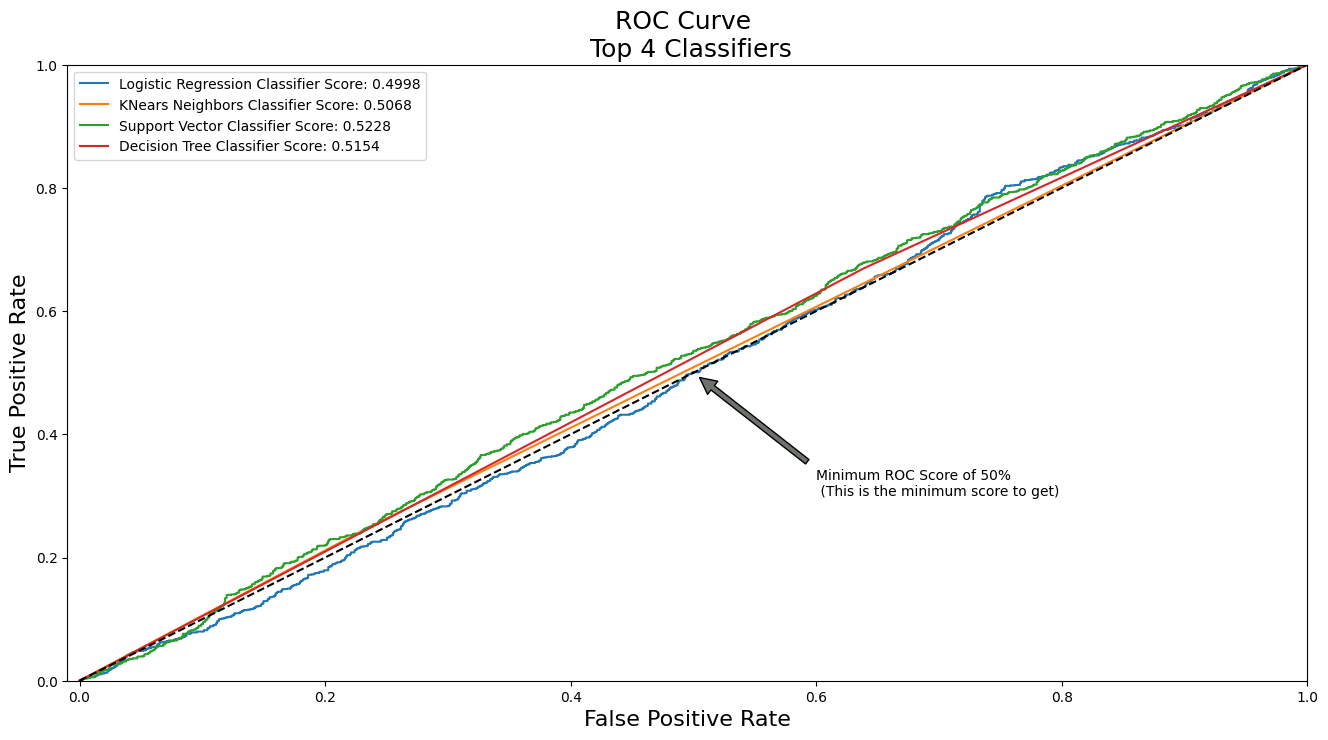

In [40]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()
